<a href="https://colab.research.google.com/github/ryyutku/DSGP/blob/anuk/Modelling/Model%202/Demand_forecast_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit

In [6]:
files = ["Avg_Daily_Sales_Litres_ceypetco.csv","Avg_Daily_Sales_MT_ceypetco.csv","CIEC Data.csv","GDP_historical_data.csv","Import_Data_WITS.csv","Population_colombo.csv","Sales_IOC.csv","Transport_Report_Tables.csv" ]

In [7]:
ceypetco_sales_l_df = pd.read_csv(files[0]) # int64
ceypetco_sales_m_df = pd.read_csv(files[1]) # int64
ciec_df = pd.read_csv(files[2]) # float64
gdp_df = pd.read_csv(files[3]) # converted to float64
import_df = pd.read_csv(files[4]) # contains float64, int64 for years, object for the partner names and countries
population_df = pd.read_csv(files[5]) # converted float64
ioc_sales_df = pd.read_csv(files[6]) # converted to float64
transport_df = pd.read_csv(files[7]) # converted to float64

In [8]:
# Converting the ioc_sales data into float
ioc_sales_df = ioc_sales_df.replace({r'[\n,]': ''}, regex=True)
ioc_sales_df = ioc_sales_df.astype(float)

In [9]:
# Converting the gdp historical data into float
gdp_df = gdp_df.replace({r'[$%B,]':''},regex=True)
gdp_df = gdp_df.replace('',np.nan)
gdp_df = gdp_df.astype(float)

In [10]:
# converting the population df to float
population_df = population_df.replace({r'[,%]':''},regex=True)
population_df = population_df.replace('',np.nan)
population_df = population_df.astype(float)

In [11]:
# converting the transport df to float
transport_df_str = transport_df.iloc[:,0:2]
transport_df_n = transport_df.iloc[:, 2:].replace({r'[,%]':''},regex=True)
transport_df_n = transport_df_n.astype(float)
transport_df = transport_df_str.join(transport_df_n)

In [12]:
ciec_df['date'] = pd.to_datetime((ciec_df['date']))

In [13]:
ciec_df.columns

Index(['date', 'fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties ',
       'Foreign Direct Investments', 'GDP Goods and Services',
       'GDP: Gross National Income', 'Government Debt',
       'New Vehicle Registrations', 'Vehicle Sales', 'Port Stay Duration',
       'Vehicle Sales Asia', 'No.of Vessels Colombo',
       'Imports of Refined Products', 'Colombo port calls',
       'Tax income profits_gains', 'Tax on Export', 'Tax Goods & Services',
       'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price',
       'Petrol User Price', 'Consumption_Oil', 'Sales 90 Octane',
       'Sales 95 Octane', 'Sales Auto Diesel', 'Household_income',
       'Fuel_other_manufacture'],
      dtype='object')

In [14]:
ciec_df_cols = ['date', 'fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties ',
       'Foreign Direct Investments', 'GDP Goods and Services',
       'GDP: Gross National Income', 'Government Debt',
       'New Vehicle Registrations', 'Vehicle Sales', 'Port Stay Duration',
       'Vehicle Sales Asia', 'No.of Vessels Colombo',
       'Imports of Refined Products', 'Colombo port calls',
       'Tax income profits_gains', 'Tax on Export', 'Tax Goods & Services',
       'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price',
       'Petrol User Price', 'Consumption_Oil', 'Sales 90 Octane',
       'Sales 95 Octane', 'Sales Auto Diesel', 'Household_income',
       'Fuel_other_manufacture']

## **Checking the relationships of the columns to see how they must be interpolated**

Checking how the columns are related to other columns, For forecasting the null values

In [15]:
def calculate_category_correlation(df,feature1, feature2):
    # Drop rows where 'feature1' is NaN
    df_valid_feature1 = df.dropna(subset=[feature1])

    # Drop rows where 'feature2' are NaN
    df_valid_feature2 = df.dropna(subset=[feature2], how='all')

    # Find the overlapping date range where both 'feature1' and the 'feature2' exist
    start_date = max(df_valid_feature1['date'].min(), df_valid_feature2['date'].min())
    end_date = min(df_valid_feature1['date'].max(), df_valid_feature2['date'].max())

    # Filter data to include only the overlapping date range
    df_filtered = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    # Compute correlation between 'fuel_consumption' and the aggregated category
    correlation = df_filtered[[feature1, feature2]].corr().iloc[0, 1]

    return correlation

In [16]:
def find_strong_correlations(df, columns, threshold=0.8):
  strong_correlations = {}
  for i in columns:
    for j in columns:
      if i != j:
        correlation = calculate_category_correlation(df, i, j)
        if abs(correlation) >= threshold:
          if i not in strong_correlations:
            strong_correlations[i] = []
          strong_correlations[i].append((j,correlation))


  if strong_correlations:
    print("THE STRONG CORRELATIONS")
    for feature, related_features  in strong_correlations.items():
      for related_feature, corr in related_features:
        print(f"{feature} and {related_feature} have a correlation of {corr:.2f}")
  else:
    print("NO STRONG CORRELATIONS")

  return strong_correlations


In [17]:
strong_correlations = find_strong_correlations(ciec_df,ciec_df_cols)

THE STRONG CORRELATIONS
date and fuel_consumption have a correlation of 0.87
date and GDP Goods and Services have a correlation of 0.91
date and GDP: Gross National Income have a correlation of 0.93
date and Government Debt have a correlation of 0.94
date and Imports of Refined Products have a correlation of 0.88
date and Tax income profits_gains have a correlation of 0.81
date and Tax Goods & Services have a correlation of -0.93
date and GDP FCE Households have a correlation of 0.89
date and Petrol User Price have a correlation of -0.87
date and Consumption_Oil have a correlation of 0.94
date and Sales 90 Octane have a correlation of 0.96
date and Sales 95 Octane have a correlation of 0.83
date and Sales Auto Diesel have a correlation of 0.88
date and Household_income have a correlation of 0.95
fuel_consumption and date have a correlation of 0.87
fuel_consumption and Vehicle Sales have a correlation of 0.83
fuel_consumption and Petrol User Price have a correlation of -0.84
fuel_consum

In [18]:
ciec_df.isnull().mean() *100

,0
date,0.000000
fuel_consumption,18.581560
petroleum_imports_crudeOil,40.815603
Taxes_on_Customs_and_Other_Import Duties,37.092199
Foreign Direct Investments,59.326241
GDP Goods and Services,72.695035
GDP: Gross National Income,72.695035
Government Debt,80.106383
New Vehicle Registrations,22.588652
Vehicle Sales,72.234043


**Null value analysis**\
0-10% - date, consumption_oil

10-30% - fuel_consumption, New Vehicle Registrations (Interpolation will be applied)

30-50% -petroleum_imports_crude_oil, Taxes_on_Customs_and_Other_Import Duties, Imports of Refined Products, Tax income profits_gains, Tax Goods & Services, Diesel User Price, Petrol User Price, Sales 90 Octane, Sales Auto Diesel,

50% + - Foreign Direct Investments, GDP Goods and Services, GDP: Gross National Income, GDP: Gross National Income, Government Debt, Vehicle Sales, Port Stay Duration, Vehicle Sales Asia, No.of Vessels Colombo, Colombo port calls, Tax on Export, Tax Road Transport, GDP FCE Households, Sales 95 Octane, Household_income, Fuel_other_manufacture. (Interplation will be applied)

**Need to cutdown the range from which data is considered, few possible time frames to start with are 1990,1999,2005,2006,2010 **

## **Checking what type relations the columns follow**

Analyzing the column trends to have a better understanding before using any interpolating techniques

Checking for the following trends: \
* Linear Trends
* Seasonal Trends
* Stationay Trends
* Exponental Trends
* Polynomial Trends
* Piecewise Trends

In [19]:
def analyze_column_trend(df, column, plot=True):
  df = df.copy()
  df = df.dropna(subset=[column]) # dropping the nulls before analysis

  trends = {}
  # Checking for "Linear" Trends
  x = np.arange(len(df))
  y = df[column].values
  slope, intercept, r_value, _, _ = linregress(x,y)

  #If correlation is strong the relation is linear
  if abs(r_value) > 0.8:
    trends["Linear"] = True
  else:
    trends["Linear"] = False

  # Checking for Stationary usng Augmented Dickey-Fuller test
  adf_test = adfuller(df[column].dropna(), autolag="AIC")
  p_value = adf_test[1]

  if p_value < 0.05:
    trends["Stationary"] = True
  else:
    trends["Stationary"] = False

  # Checking fo "Exponential" Trend
  y_log = np.log(y+1e-8) # To avoid log errors
  slope_log, _, r_value_log, _, _ = linregress(x,y_log)

  trends["Exponential"] = abs(r_value_log) > 0.8

  # Checking for "Seasonality" using seasonal decomposition
  try:
    decomposition = sm.tsa.seasonal_decomponse(df[column], period=12, model='additive')
    trends["Seasonal"] = True if np.max(decomposition.seasonal) > 0 else False
  except:
    trends["Seasonal"] = False

  # Checking for "Polynomial"
  poly = PolynomialFeatures(degree=2)
  X_poly = poly.fit_transform(x.reshape(-1,1))
  model = LinearRegression().fit(X_poly, y)
  poly_r2 = model.score(X_poly, y)

  trends["Polynomial"] = poly_r2 > 0.85

  # Checking for "Stationary" trends using Augmented Dickey-Fuller test
  adf_test = adfuller(df[column].dropna(), autolag="AIC")
  trends["Stationary"] = adf_test[1] < 0.05


  # Plotting the trends
  if plot:
    plt.figure(figsize=(5,2))
    plt.plot(df['date'], df[column], label="Original Data")
    plt.plot(df['date'], slope * x + intercept, label = "Linear Fit", linestyle="dashed", color="red")
    plt.title(f"Trend Analysis for {column}")
    plt.legend()
    plt.show()

  return trends


In [20]:
# Checking the trends in the following cols
df_trends = ciec_df.drop(columns = ['Consumption_Oil','date'])

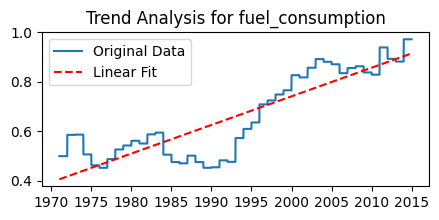

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': False}


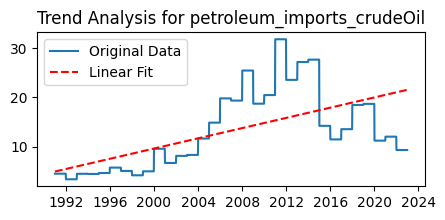

{'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


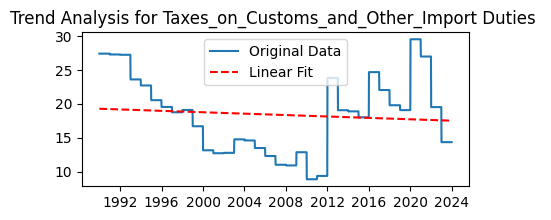

{'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


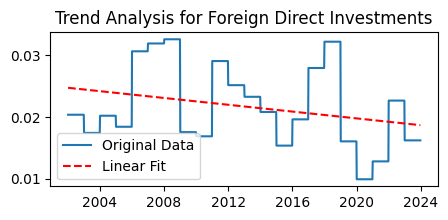

{'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


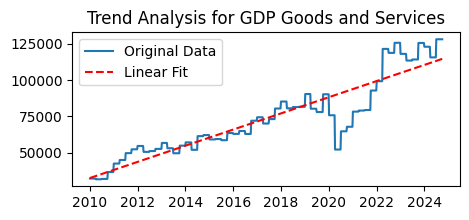

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': True}


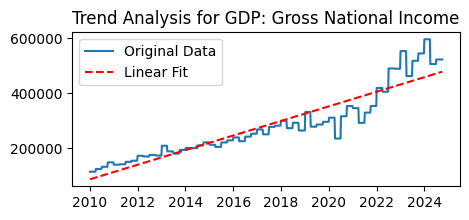

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': True}


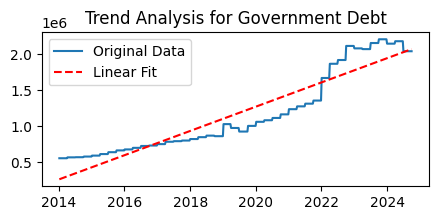

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': True}


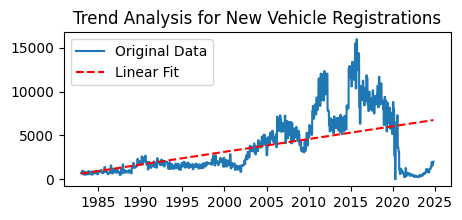

{'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


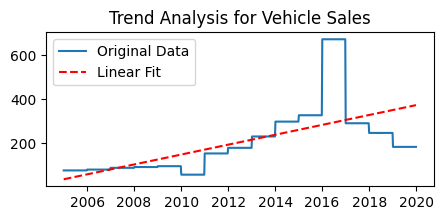

{'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


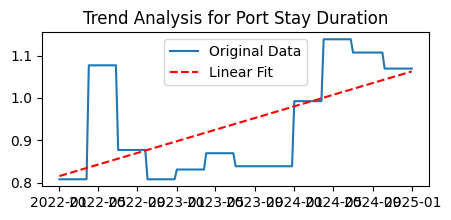

{'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


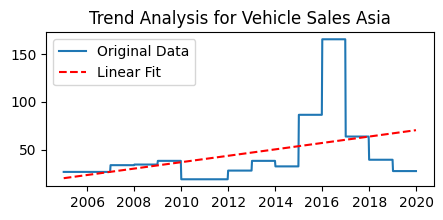

{'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


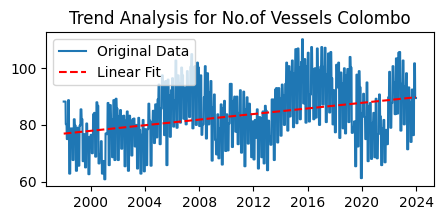

{'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


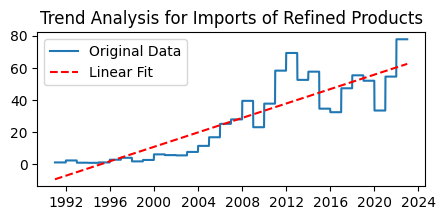

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': False}


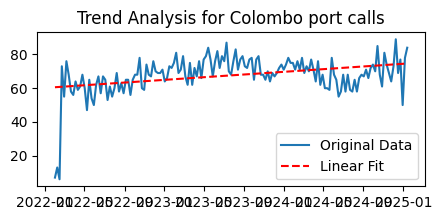

{'Linear': False, 'Stationary': True, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


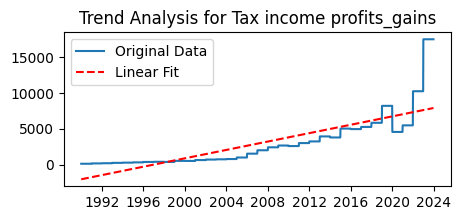

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': False}


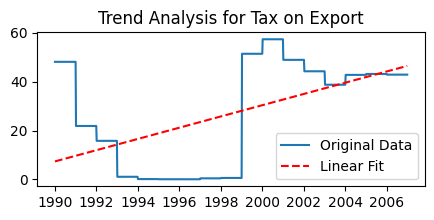

{'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


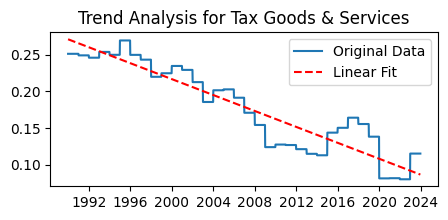

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': True}


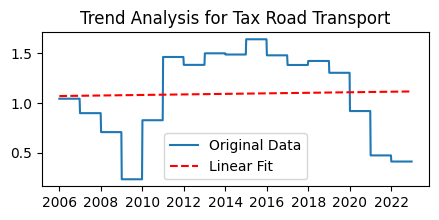

{'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


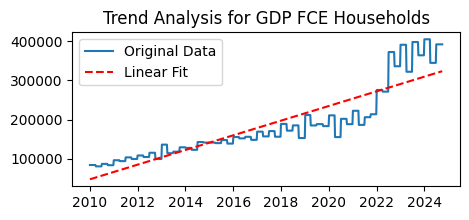

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': True}


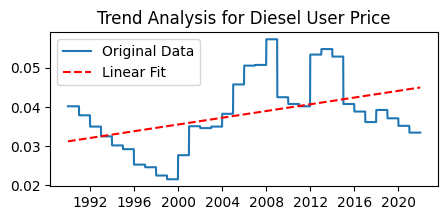

{'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


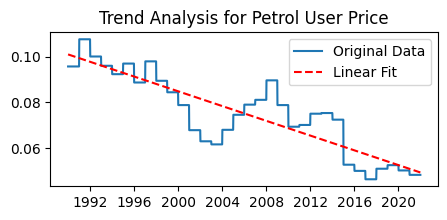

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': False}


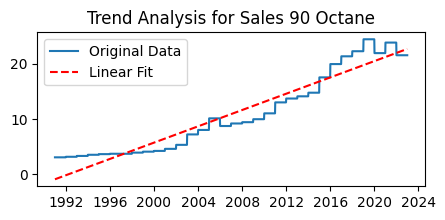

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': True}


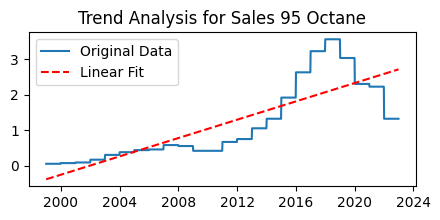

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': False}


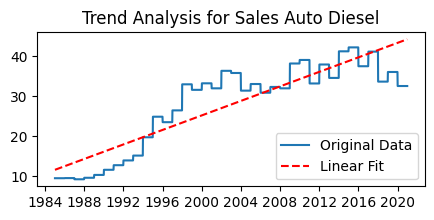

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': True}


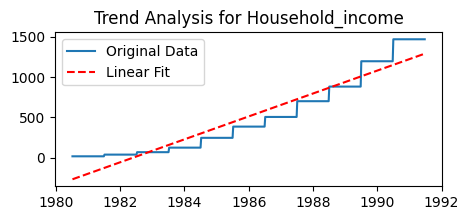

{'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': True}


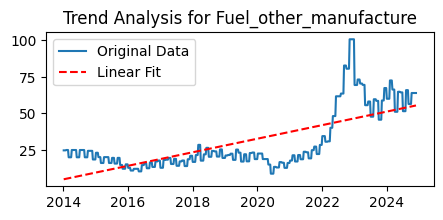

{'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}


In [21]:
Trends = {}
for i in df_trends.columns:
  column = i
  trends = analyze_column_trend(ciec_df, column)
  print(trends)
  Trends[column] = trends

In [22]:
print(Trends)

{'fuel_consumption': {'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': False}, 'petroleum_imports_crudeOil': {'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}, 'Taxes_on_Customs_and_Other_Import Duties ': {'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}, 'Foreign Direct Investments': {'Linear': False, 'Stationary': False, 'Exponential': False, 'Seasonal': False, 'Polynomial': False}, 'GDP Goods and Services': {'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': True}, 'GDP: Gross National Income': {'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': True}, 'Government Debt': {'Linear': True, 'Stationary': False, 'Exponential': True, 'Seasonal': False, 'Polynomial': True}, 'New Vehicle Registrations': {'Linear': False, 'Stationary': False, 'Exponential': False, 'Seaso

## **Using Interpolating and forecasting methods for columns with missing values**

In [23]:
def exponential_func(x,a,b):
  return a*np.exp(b*x)

In [24]:
def interpolate_feature(df, target, corr_features, method):
  df = df.copy()

  # checking if correlated features are provided
  if corr_features is None:
    raise ValueError("No correlated features provided")
  missing_rows = df[df[target].isna()]

  if missing_rows.empty:
    print("No missing values in the target column")
    return df

  if method == "linear" or method == "stationary" or method=="seasonal":
    # performing linear interpolation for correlated features
    for feature in corr_features:
      if feature in df.columns:
        df[target] = df[target].fillna(df[feature])

      df[target] = df[target].interpolate(method="linear")


  elif method == "polynomial":
    # Checking for a polynomial interpolation
    for feature in corr_features:
      if feature in df.columns:
        df[target] = df[target].fillna(df[feature])

    x = np.arange(len(df))
    y = df[target].values
    valid_idx = ~np.isnan(y)
    poly_fit = np.poly1d(np.polyfit(x[valid_idx], y[valid_idx], deg=2))
    df[target] = df[target].fillna(pd.Series(poly_fit(x), index=df.index))

  elif method == "regression":
    model = LinearRegression()
    # drop rows where any correlated feature is missing
    valid_data = df.dropna(subset=[target] + corr_features)

    if valid_data.empty:
      print("Not enough data for regression based interpolation")
      return df

    X_train = valid_data[corr_features]
    y_train = valid_data[target]
    model.fit(X_train, y_train)

    missing_data = df[df[target].isna()]
    if not missing_data.empty:
      X_missing = missing_data[corr_features]
      df.loc[df[target].isna(), target] = model.predict(X_missing)

  elif method == "exponential":
    for feature in corr_features:
      if feature in df.columns:
        df[target] = df[target].fillna(df[target])

    x = np.arange(len(df))
    y = df[target].values
    valid_idx = np.isnan(y)

    try:
      popt,_ = curve_fit(exponential_func, x[valid_idx], y[valid_idx])
      a,b = popt

      df[target] = df[target].fillna(exponential_func(x,a,b))

    except Exception as e:
      print("Exponential interpolation failed",{e})
      return df


  else:
    raise ValueError("Invlalid mehtod")

  return df

In [25]:
print(strong_correlations['fuel_consumption'])

[('date', 0.867716180153151), ('Vehicle Sales', 0.8283821219636847), ('Petrol User Price', -0.8393110671118211), ('Consumption_Oil', 0.9598220451897038), ('Sales Auto Diesel', 0.9642519644854144)]


Interpolate/forecast the rest of the null values\
Do the modelling for the target variable - preprocessing and necessary transformations

In [26]:
print(Trends.keys())

dict_keys(['fuel_consumption', 'petroleum_imports_crudeOil', 'Taxes_on_Customs_and_Other_Import Duties ', 'Foreign Direct Investments', 'GDP Goods and Services', 'GDP: Gross National Income', 'Government Debt', 'New Vehicle Registrations', 'Vehicle Sales', 'Port Stay Duration', 'Vehicle Sales Asia', 'No.of Vessels Colombo', 'Imports of Refined Products', 'Colombo port calls', 'Tax income profits_gains', 'Tax on Export', 'Tax Goods & Services', 'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price', 'Petrol User Price', 'Sales 90 Octane', 'Sales 95 Octane', 'Sales Auto Diesel', 'Household_income', 'Fuel_other_manufacture'])


In [29]:
def get_corr_features(corr_dict, target):
  if target not in corr_dict:
    raise ValueError("No correlations found for the target",target)

  return[col for col,_ in corr_dict[target]]

In [31]:
def get_trend_to_interpolate(trends_dict, target):
  if target not in trends_dict:
    raise ValueError("No trend found for the target",target)

  return [method for method, is_true in trends_dict[target].items() if is_true]


In [61]:
def interpolate_feature(df, target, strong_correlations, trends_dict):
  print("running the correlated features's get_corr_features",target)
  correlated_features = get_corr_features(strong_correlations, target)
  methods = get_trend_to_interpolate(Trends,target)

  if not correlated_features:
    print("Correlated features are not in target",target)
    return df

  if not methods:
    print("No interpolation methods for target",target)
    return df

  for method in methods:
    print("Interpolating for target",target)
    df = interpolate_feature(df, target, correlated_features, method)
    break

  return df



In [62]:
get_corr_features(strong_correlations, 'fuel_consumption')

['date',
 'Vehicle Sales',
 'Petrol User Price',
 'Consumption_Oil',
 'Sales Auto Diesel']

In [63]:
#calculating the correlation for fuel_consumption
fc_df = interpolate_feature(ciec_df, 'fuel_consumption', strong_correlations, Trends)

running the correlated features's get_corr_features fuel_consumption
Interpolating for target fuel_consumption
running the correlated features's get_corr_features fuel_consumption


ValueError: ('No correlations found for the target', 'fuel_consumption')

In [64]:
# calculating the interpolation for all of the features mentioned
def calc_interpolation_all(df, strong_correlations, trends_dict):
  for target in df.columns:
    df = interpolate_feature(df, target, strong_correlations, trends_dict)

  return df

In [52]:
excluded_columns = ['date', 'Consumption_Oil']

# Copy the original DataFrame
to_interpolate_df = ciec_df.copy()

# Separate the excluded columns
excluded_df = to_interpolate_df[excluded_columns]  # Save 'date' and 'Consumption_Oil'

# Drop the excluded columns before interpolation
to_interpolate_df = to_interpolate_df.drop(columns=excluded_columns, errors='ignore')

In [55]:
interpolated_df = calc_interpolation_all(to_interpolate_df, strong_correlations, Trends)

Interpolating for target fuel_consumption


ValueError: ('No correlations found for the target', 'fuel_consumption')

## **Scaling and Normalizing the Data**

## **Building the Demand Proxy Feature Column**